# Tools
https://langchain-ai.github.io/langgraph/concepts/tools/#tool-calling

## ToolNode
https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_node.ToolNode

## Validation Node
https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_validator.ValidationNode

### Pre-built LangChain Tools

**Pre-built LangChain tools**
https://python.langchain.com/docs/integrations/tools/

**Community tools**
https://python.langchain.com/api_reference/community/tools.html

### Custom tool
https://langchain-ai.github.io/langgraph/concepts/tools/#custom-tools

### Tool execution
LangGraph provides a prebuilt component for tools.

**Tool call**
https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolCall.html

[ToolNode](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_node.ToolNode) :A prebuilt node that executes tools. 
* A node that runs the tools called in the last AIMessage.
* Multiple tools if specified in AIMessage = tools run in parallel
* [AIMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.ai.AIMessage.html)

[create_react_agent](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent) : Constructs a full agent that manages tool calling automatically.


In [1]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from typing import List, Annotated, TypedDict
import operator
from IPython.display import Image, display

@tool
def multiply(number_1: int, number_2: int) -> int:
    """Multiply two numbers."""
    return number_1 * number_2

@tool
def add(number_1: int, number_2: int) -> int:
    """Add two numbers."""
    return number_1 + number_2

@tool
def subtract(number_1: int, number_2: int) -> int:
    """Subtract two numbers."""
    return number_1 - number_2

# Create an instance of tool node
tool_node = ToolNode(
    name = "tool_node",
    tools = [multiply,add,subtract]
)


### 1. Invoke tool with an AIMessage

In [2]:

# Setup AI message with tool_calls
tool_call_message = AIMessage(
    content = "dummy",
    # Add one or more tool calls
    tool_calls = [
        {"name": "multiply", "args": {"number_1": 5, "number_2": 3}, "id": "dummy"}
    ]
)

# Setup messages
messages = {"messages": [tool_call_message]}

# Invoke the tool node to simulation realtime execution driven by LLM
response = tool_node.invoke(messages)

response

{'messages': [ToolMessage(content='15', name='multiply', tool_call_id='dummy')]}

### 2. Invoke multiple tools in parallel

In [3]:
tool_call_message_multiple = AIMessage(
    content = "dummy",
    tool_calls = [
                    {"name": "multiply", "args": {"number_1": 5, "number_2": 3}, "id": "dummy"},
                    {"name": "add", "args": {"number_1": 5, "number_2": 3}, "id": "dummy"},
                    {"name": "subtract", "args": {"number_1": 5, "number_2": 3}, "id": "dummy"}
    ]
)

# Setup messages
messages = {"messages": [tool_call_message_multiple]}

# Invoke tool node
response = tool_node.invoke(messages)

response

{'messages': [ToolMessage(content='15', name='multiply', tool_call_id='dummy'),
  ToolMessage(content='8', name='add', tool_call_id='dummy'),
  ToolMessage(content='2', name='subtract', tool_call_id='dummy')]}

## 3. Use ToolNode in workflow

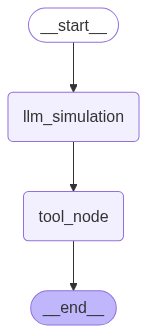

In [4]:
# Define state using the MessagesState as the base class
class StateToolsDemo(MessagesState):
    number_1: int
    number_2: int
    ops : List[str]

# Simulates execution of an LLM
def llm_simulation(state: StateToolsDemo)->StateToolsDemo:
    tool_calls = []
    for op in state["ops"]:
        tool_calls.append({"name": op, "args": {"number_1": state["number_1"], "number_2": state["number_2"]}, "id": "dummy"})

    # Simulation : LLM requests for execution of multiple operations
    # Setup messages
    tool_call_message_multiple = AIMessage(
        content = "dummy",
        tool_calls = tool_calls
    )

    messages = {"messages": tool_call_message_multiple}
    return messages


# Tool node
tool_node = ToolNode(
    name = "tool_node",
    tools = [multiply,add,subtract],
    handle_tool_errors = True
)

# Create the state graph builder
workflow_builder = StateGraph(StateToolsDemo)

workflow_builder.add_node("llm_simulation", llm_simulation)
workflow_builder.add_node("tool_node", tool_node)
workflow_builder.add_edge(START, "llm_simulation")
workflow_builder.add_edge("llm_simulation", "tool_node")
workflow_builder.add_edge("tool_node", END)

workflow_compiled = workflow_builder.compile()

# Display
display(Image(workflow_compiled.get_graph().draw_mermaid_png()))


In [6]:
# Invoke
ops = ["multiply","add","subtract"]
response = workflow_compiled.invoke({"number_1": 15, "number_2": 7, "ops" : ops})

for message in response["messages"]:
    print(type(message), "\n   ", message)
    print("------------------------------------")

<class 'langchain_core.messages.ai.AIMessage'> 
    content='dummy' additional_kwargs={} response_metadata={} id='d6b3329e-c048-4f34-a937-1fb355f6e08c' tool_calls=[{'name': 'multiply', 'args': {'number_1': 15, 'number_2': 7}, 'id': 'dummy', 'type': 'tool_call'}]
------------------------------------
<class 'langchain_core.messages.tool.ToolMessage'> 
    content='105' name='multiply' id='8f14c5a6-2418-43c1-baed-b44cd59ae20c' tool_call_id='dummy'
------------------------------------


### 4. Error handling

Demonstrates the error handling via simulation.

In [ ]:
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode

# Set the handle_tool_errors = False so an exception is thrown when tool is executed
tool_node_with_error_handling = ToolNode(
    name = "tool_node",
    tools = [multiply,add,subtract],
    handle_tool_errors = False
)

operation = "multiply"
tool_call_message = AIMessage(
    content = "dummy",
    tool_calls = [{"name": operation, "args": {"number_1": 5, "number_2": 3}, "id": "dummy"}]
)

# Create the request dictionary
messages_list = [tool_call_message]
messages = {"messages": messages_list}

# Put the invoke in a try-except block to handle error
try:
    response = tool_node_with_error_handling.invoke(messages)
except Exception as error:
    print("------ Error -----")
    print(error)

print("------ Response -----")
print(response)